The project proceeds in the order of **data preprocessing - model - conclusion**.

- At the model part, emotion analysis using word dictionary, n-gram applying deep learning, etc. were used. In order to compensate the limitation of natural language processing, Lightgbm machine learning model was used and reliability was further secured through usefulcount.
- In the end, we have showed the limitations and weak points of conclusion and analysis of the project.

# Data preprocessing

### 1.1. Data exploration
[Link to Data](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29)\
**Data is comprised of reviews from online pharmaceutical sites.**

In [379]:
# Importing packages

import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import os
import string
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [380]:
df_train = pd.read_csv("input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv", parse_dates=["date"])
df_test = pd.read_csv("input/kuc-hackathon-winter-2018/drugsComTest_raw.csv", parse_dates=["date"])

In [381]:
print("Train shape :" ,df_train.shape)
print("Test shape :", df_test.shape)

Train shape : (161297, 7)
Test shape : (53766, 7)


In [382]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


There are six variables except for the **unique ID** that identifies the individual, and review is the key variable.

- **drugName (categorical):** name of drug 
- **condition (categorical):** name of condition
- **review (text):** patient review 
- **rating (numerical):** 10 star patient rating 
- **date (date):** date of review entry 
- **usefulCount (numerical):** number of users who found review useful



**The structure of the data:**
- Patient with a unique ID purchases a drug that meets his condition
- Patient writes a review and gives rating for the drug he/she purchased on the date
- If the others read that review and find it helpful, they will click usefulCount, which will add 1 for the variable.

### 1.2. Data understanding

- Here, we have compared the unique number of unique IDs and the length of the train data
- To check if the number of reviews and number of unique IDs created match, to make sure that same customer hasn't written multiple reviews
- To make sure there weren't more than one review for one customer.

In [383]:
print("unique ID count of train dataset : " ,len(set(df_train['uniqueID'].values)))
print("length of train dataset : " ,df_train.shape[0])

unique ID count of train dataset :  161297
length of train dataset :  161297


**Note:**
- **DrugName** is closely related to **condition**, so we have analyzed them together.
- The unique values of the two variables are 3671 and 917, respectively, and there are about 4 drugs for each condition.
- Detailed visualization ahead.

Next:
- We have combined the original training and testing sets into a single dataframe as it makes sense in pre-processing (when you apply the same technique of imputation of missing values or do the feature engineering on a joint dataframe).
- Later, we will split the united dataframe back into training and testing sets at the end, before start ML model training and model forecasting.

In [384]:
df_all = pd.concat([df_train,df_test])

Text(0.5, 1.0, 'Top 20 conditions : The number of drugs per condition.')

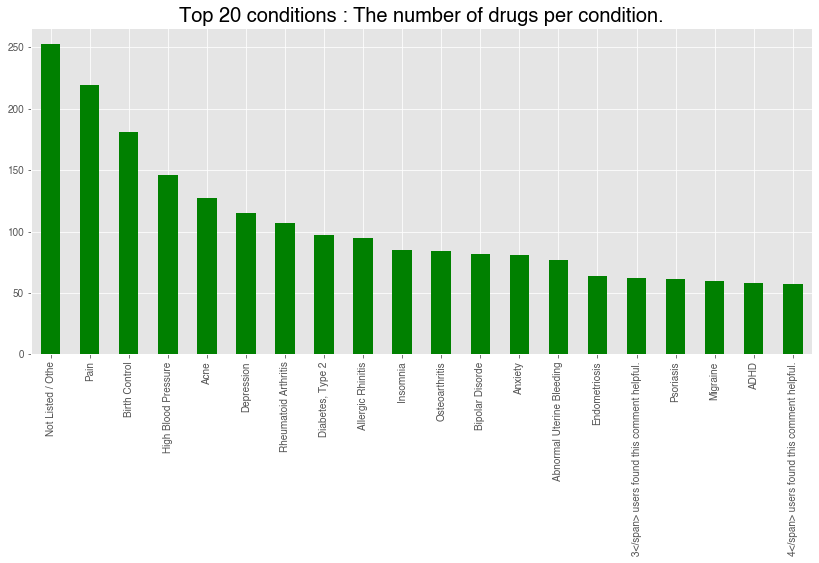

In [385]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

plt.style.available
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top 20 conditions : The number of drugs per condition.", fontsize = 20)

- The visualisation above shows the number of drugs for top eight conditions having an average of 100 for each condition.
- On the other hand, it should be noted that the phrase "3</span> users found this comment helpful" appears in the condition, is an error in the crawling process, to be removed from data

In [386]:
df_all[df_all['condition']=='3</span> users found this comment helpful.'].head(3)

,uniqueID,drugName,condition,review,rating,date,usefulCount
243,81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3,2010-06-01,3
1864,124318,Skyla,3</span> users found this comment helpful.,"""Never pregnant,28,retroverted small (6cm) ute...",1,2015-12-16,3
3322,202848,ProAir HFA,3</span> users found this comment helpful.,"""I get chest colds and asthmatic symptoms in t...",9,2015-12-12,3


Text(0.5, 1.0, 'Bottom 20 conditions : The number of drugs per condition.')

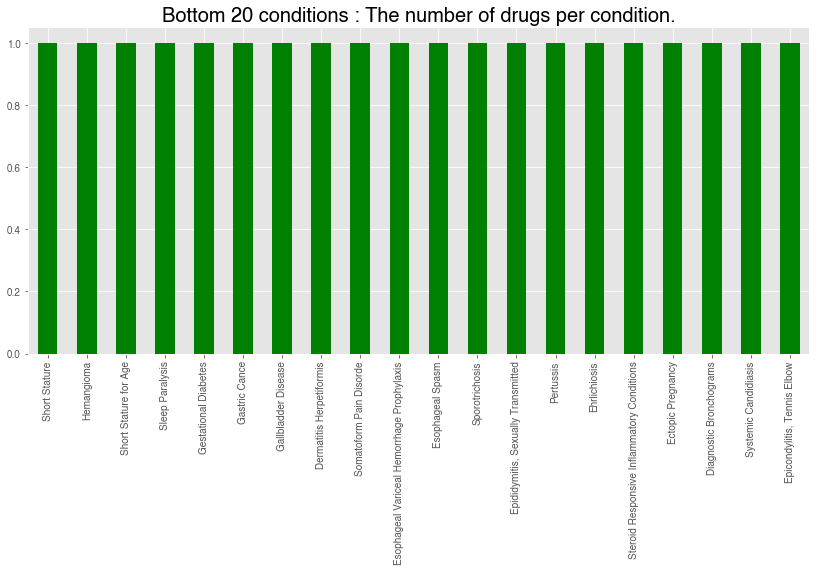

In [387]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-20:condition_dn.shape[0]].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.style.available
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom 20 conditions : The number of drugs per condition.", fontsize = 20)

**Note:**
- All the bottom 20 conditions have 1 drug per conditions
- Since, our recommendation system needs to prescribe the best suited drug, we will only analyze the conditions that have at least 2 drugs per condition.

Next, need to review the reviews. First, noticeable parts are the html strings like \ r \ n, and the parts that express emotions in parentheses such as (very unusual for him) and (a good thing) and words in capital letters like MUCH.

In [388]:
df_train['review'][1]

'"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."'

In addition, there were some words with errors like didn&# 039;t for didn't, and also characters like ...

In [389]:
df_train['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

**Need to delete these parts.**

#### Word Cloud

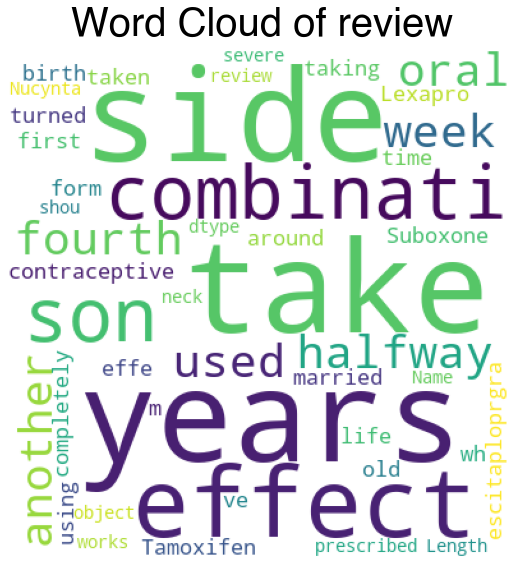

In [390]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc kernel 
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(12.0,8.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df_all["review"], title="Word Cloud of review")

Next, we will classify 1 ~ 5 as negative, and 6 ~ 10 as positive, and we will check through 1 ~ 4 grams which corpus best classifies emotions.

In [391]:
from collections import defaultdict
df_all_6_10 = df_all[df_all["rating"]>5]
df_all_1_5 = df_all[df_all["rating"]<6]

In [392]:
## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from rating  8 to 10 review ##
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from rating  4 to 7 review ##
freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of rating 1 to 5", 
                                          "Frequent words of rating 6 to 10"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

When you use 1-gram, you can see that the top 5 words have the same contents, although the order of left (negative) and right (positive) are different. This means when we analyze the text with a single corpus, it does not classify the emotion well. So, we will expand the corpus.

In [393]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent biagrams of rating 1 to 5", 
                                          "Frequent biagrams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

Likewise, in 2-gram, the contents of the top five corpus are similar, and it is hard to classify positive and negative. In addition, 'side effects' and 'side effects.' are interpreted differently, which means preprocessing of review data is necessary. However, you can see that this is better to classify emotions rather than previous 1-grams, like side effects, weight gain, and highly recommend.

In [394]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent trigrams of rating 1 to 5", 
                                          "Frequent trigrams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

From 3-gram you can see that there is a difference between positive and negative corpus. Bad side effects, birth control pills, negative side effects are corpus that classify positive and negative. However, both positive and negative parts can be thought that it has missing parts that reverses the context, such as' not' in front of a corpus.

In [395]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent 4-grams of rating 1 to 5", 
                                          "Frequent 4-grams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="4-grams Count Plots")
py.iplot(fig, filename='word-plots')

Clearly, 4-gram classifies emotions much betther than other grams. Therefore, we will use 4-gram to build deep learning model.

Next, we will look for relationship between rating and weather. First of all, we will count the number of ratings.

Text(0.5, 1.0, 'Count of rating values')

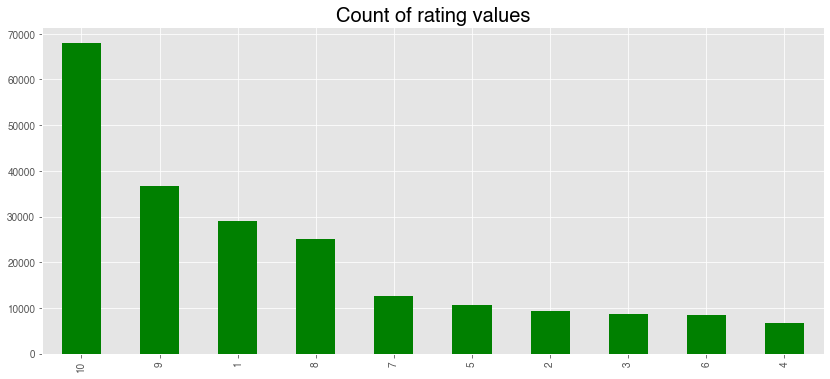

In [396]:
rating = df_all['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of rating values", fontsize = 20)

Most people choose four values; 10, 9, 1, 8, and the number of 10 is more than twice as many as the others. With this, we can see that the percentage of positives is higher than negative, and people's reactions are extreme.

Next, we will check the number of reviews and percentage of ratings according to weather.

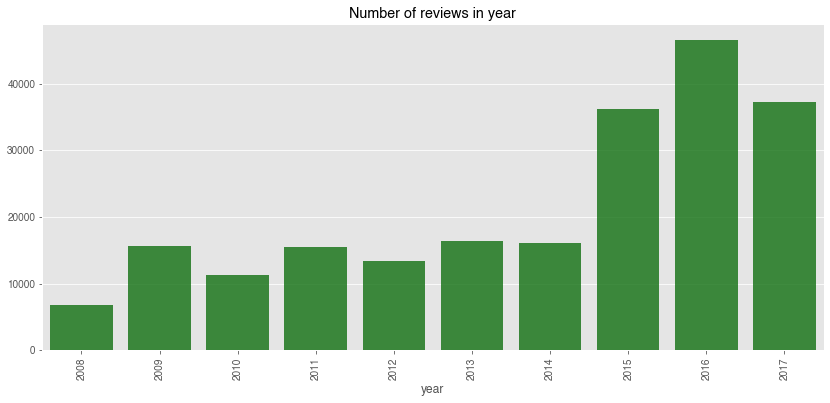

In [397]:
# Code in https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
# SRK - Simple Exploration Notebook 

cnt_srs = df_all['date'].dt.year.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('year', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in year")
plt.show()

Text(0.5, 1.0, 'Mean rating in year')

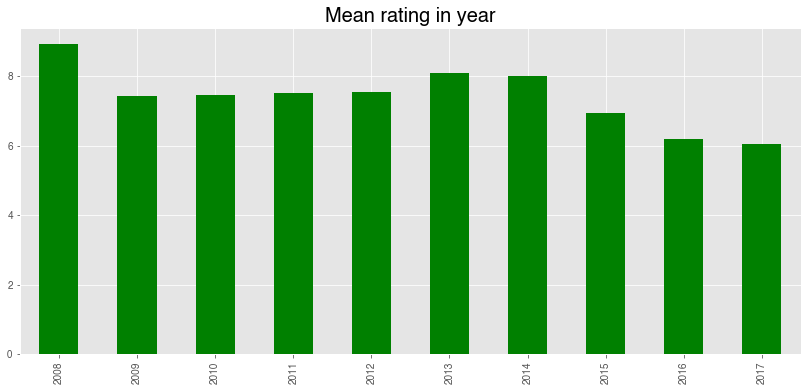

In [398]:
df_all['year'] = df_all['date'].dt.year
rating = df_all.groupby('year')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in year", fontsize = 20)

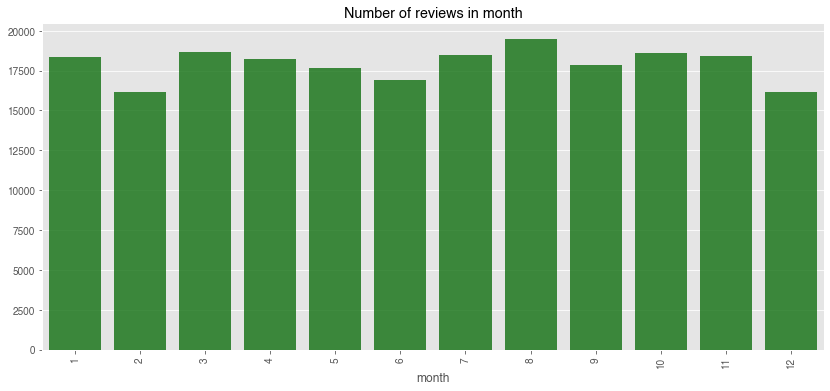

In [399]:
# Code in https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
# SRK - Simple Exploration Notebook 

cnt_srs = df_all['date'].dt.month.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('month', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in month")
plt.show()

Text(0.5, 1.0, 'Mean rating in month')

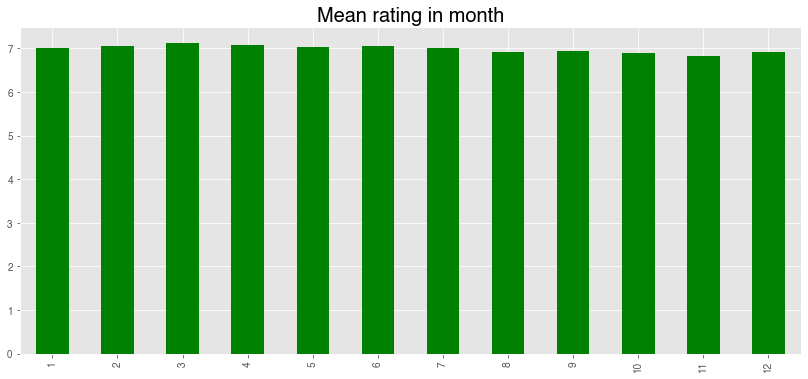

In [400]:
df_all['month'] = df_all['date'].dt.month
rating = df_all.groupby('month')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in month", fontsize = 20)

Interestingly, you can see that the average rating differs by year, but it is similar by month.

Text(0.5, 1.0, 'Mean rating in day')

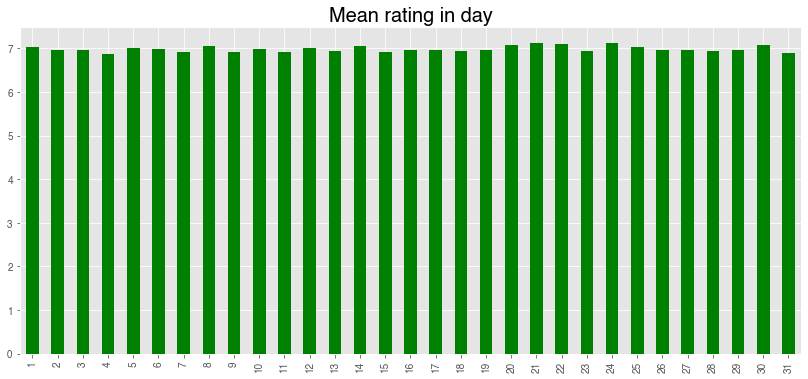

In [401]:
df_all['day'] = df_all['date'].dt.day
rating = df_all.groupby('day')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in day", fontsize = 20)

We checked whether the day of the week affects the rating like salary day, but it does not make a big difference.

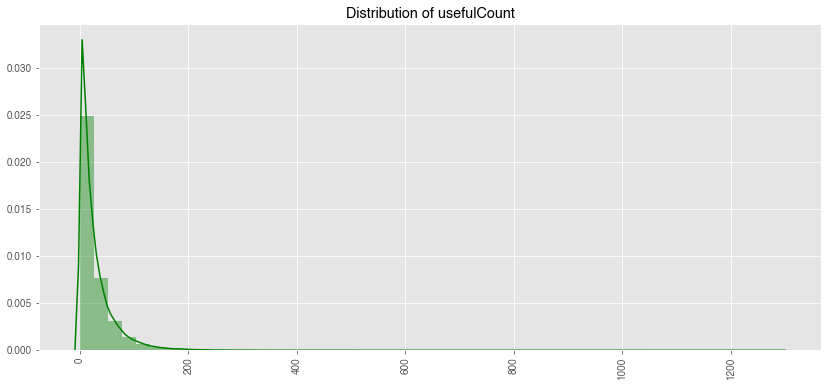

In [402]:
plt.figure(figsize=(14,6))
sns.distplot(df_all["usefulCount"].dropna(),color="green")
plt.xticks(rotation='vertical')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Distribution of usefulCount")
plt.show()

In [403]:
df_all["usefulCount"].describe()

count    215063.000000
mean         28.001004
std          36.346069
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64

**Note:**
- Looking at the distribution of usefulCount, you can see that the difference between minimum and maximum is 1291, which is high.
- In addition, the deviation is huge, which is 36. The reason for this is that the more drugs people look for, the more people read the review no matter their contents are good or bad, which makes the usefulcount very high.
- While creating the model, we have normalized it by conditions, considering people's accessibility.

### 1.3 Missing value

Text(0.5, 1.0, 'Total Missing Value ')

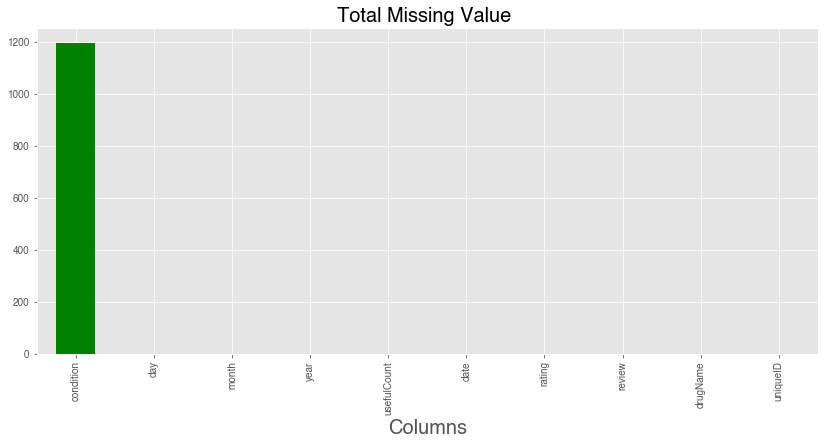

In [404]:
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [405]:
print("Missing value (%):", 1200/df_all.shape[0] *100)

Missing value (%): 0.5579760349292998


We will delete because the percentage is lower than 1%.

## 2. Date Preprocessing

### 2.1. Missing Values Removal

In [406]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

Text(0.5, 1.0, 'Total Missing Value ')

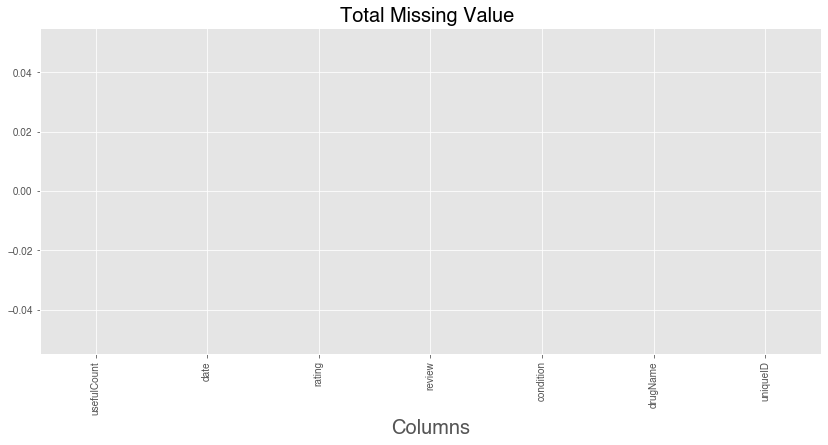

In [407]:
df_all = pd.concat([df_train,df_test]).reset_index()
del df_all['index']
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

### 2.2 Condition Preprocessing

We will delete the sentences with the form above.

In [408]:
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)

In [409]:
new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

Next, delete conditions with only one drug.

In [410]:
df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
816,Hemangioma,1
817,Q Feve,1
818,Urinary Retention,1
819,Diagnostic Bronchograms,1
820,Steroid Responsive Inflammatory Conditions,1
821,Cluster-Tic Syndrome,1
822,Nausea (phosphorated carbohydrate solution),1
823,Ramsay Hunt Syndrome,1
824,Rat-bite Feve,1
825,Hemorrhoids (pramoxine / zinc oxide),1


In [411]:
df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()
df_condition_1['condition'][0:10]

0                           Uveitis, Posteri
1                    Pseudogout, Prophylaxis
2                        Infectious Diarrhea
3                   Thyroid Suppression Test
4                                 Angioedema
5                                Scleroderma
6                                        mis
7            Anti NMDA Receptor Encephalitis
8                                     mist (
9    Pruritus of Partial Biliary Obstruction
Name: condition, dtype: object

In [412]:
all_list = set(df_all.index)
condition_list = []
for i,j in enumerate(df_all['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

### 2.3 Review Preprocessing

In [413]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [414]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/DeliciaFernades/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

- \r\n : we need to convert html grammer
- ... , &#039; : deal with not alphabet

In [415]:
stops = set(stopwords.words('english'))
#stops

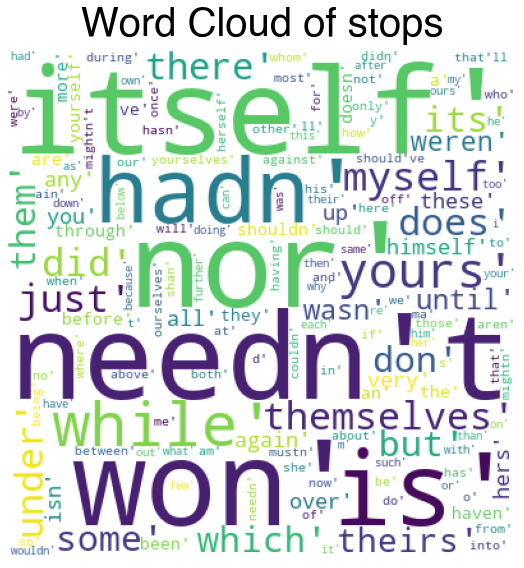

In [416]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc kernel 
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(12.0,8.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(stops, title="Word Cloud of stops")

First, let's see what words are used as stopwords. There are many words that include not, like needn't. These words are key parts of emotional analysis, so we will remove them from stopwords.

In [417]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [418]:
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [419]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [420]:
%time df_all['review_clean'] = df_all['review'].apply(review_to_words)

CPU times: user 2min 23s, sys: 647 ms, total: 2min 24s
Wall time: 2min 24s


## 3. Model

### 3.1. Deep Learning Model Using N-gram

In [421]:
# Make a rating
df_all['sentiment'] = df_all["rating"].apply(lambda x: 1 if x > 5 else 0)

In [422]:
df_train, df_test = train_test_split(df_all, test_size=0.33, random_state=42) 

In [423]:
# https://github.com/corazzon/KaggleStruggle/blob/master/word2vec-nlp-tutorial/tutorial-part-1.ipynb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(4, 4),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(max_features=20000, min_df=2, ngram_range=(4, 4))

In [424]:
#https://stackoverflow.com/questions/28160335/plot-a-document-tfidf-2d-graph
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [425]:
%time train_data_features = pipeline.fit_transform(df_train['review_clean'])
%time test_data_features = pipeline.fit_transform(df_test['review_clean'])

CPU times: user 31.5 s, sys: 981 ms, total: 32.4 s
Wall time: 32.5 s
CPU times: user 17.6 s, sys: 547 ms, total: 18.2 s
Wall time: 18.2 s


In [426]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

# 0. Package
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import random

In [427]:
# 1. Dataset
y_train = df_train['sentiment']
y_test = df_test['sentiment']
solution = y_test.copy()

# 2. Model Structure
model = keras.models.Sequential()

model.add(keras.layers.Dense(200, input_shape=(20000,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(300))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# 3. Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 200)               4000200   
_________________________________________________________________
batch_normalization_12 (Batc (None, 200)               800       
_________________________________________________________________
activation_12 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 300)               60300     
_________________________________________________________________
batch_normalization_13 (Batc (None, 300)               1200      
_________________________________________________________________
activation_13 (Activation)   (None, 300)              

**Saving checkpoints**

In [428]:
# # !mkdir -p training_1
# checkpoint_path = "output/training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)


In [429]:
# 4. Train model
# hist = model.fit(train_data_features, y_train, epochs=10, batch_size=64, callbacks=[cp_callback])  # Passed callback to training

**Reload Model**

In [430]:
# os.listdir(checkpoint_dir)

In [431]:
# # Loads the weights
# model.load_weights(checkpoint_path)


In [432]:
# 5. Traing process
%matplotlib inline
import matplotlib.pyplot as plt

# fig, loss_ax = plt.subplots()

# acc_ax = loss_ax.twinx()

# loss_ax.set_ylim([0.0, 1.0])
# acc_ax.set_ylim([0.0, 1.0])

# loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# acc_ax.plot(hist.history['acc'], 'b', label='train acc')

# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuray')

# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

# plt.show()

# 6. Evaluation
# loss_and_metrics, acc = model.evaluate(test_data_features, y_test, batch_size=32, verbose=2)
# print("Model accuracy: {:5.2f}%".format(100 * acc))
# print('loss_and_metrics : ' + str(loss_and_metrics))

### Saving & loading models manually

In [433]:
# # Save the weights
# !mkdir -p checkpoints
# model.save_weights('checkpoints/my_checkpoint')

# Restore the weights
# model.load_weights('checkpoints/my_checkpoint')

In [436]:
# Save the entire model as a SavedModel.
# !mkdir -p saved_model
# model.save('saved_model/my_model')

In [437]:
ls

input/
output/
personalized-treatment-recommendation.ipynb


In [440]:
# # my_model directory
# ls saved_model

# # Contains an assets folder, saved_model.pb, and variables folder.
# ls my_model

In [443]:
new_model = keras.models.load_model('output/saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               4000200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               60300     
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
activation_2 (Activation)    (None, 300)              

In [447]:
new_model

In [449]:
model

In [452]:
# # Evaluate the restored model
# loss_and_metrics, acc = new_model.evaluate(test_data_features, y_test, batch_size=32, verbose=2)

In [453]:
# # Evaluate the restored model
# loss_and_metrics, acc = model.evaluate(test_data_features, y_test, batch_size=32, verbose=2)

In [454]:
# print("Model accuracy: {:5.2f}%".format(100 * acc))
# print('loss_and_metrics : ' + str(loss_and_metrics))

Onwards,

In [455]:
sub_preds_deep = model.predict(test_data_features,batch_size=32)

InvalidArgumentError: indices[3] = [3,16382] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

### 3.2 Lightgbm

To improve the low accuracy, we will use machine learning. First of all, this is the sentiment analysis model using only usefulCount.

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['sentiment']
feats = ['usefulCount']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

In [ ]:
solution = df_test['sentiment']
confusion_matrix(y_pred=sub_preds, y_true=solution)

We will add variables for higher accuracy.

In [ ]:
len_train = df_train.shape[0]
df_all = pd.concat([df_train,df_test])
del df_train, df_test;
gc.collect()

In [ ]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['day'] = df_all['date'].dt.day
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month

In [ ]:
from textblob import TextBlob
from tqdm import tqdm
reviews = df_all['review_clean']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment"] = Predict_Sentiment
df_all.head()

In [ ]:
np.corrcoef(df_all["Predict_Sentiment"], df_all["rating"])

In [ ]:
np.corrcoef(df_all["Predict_Sentiment"], df_all["sentiment"])

In [ ]:
reviews = df_all['review']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment2"] = Predict_Sentiment

In [ ]:
np.corrcoef(df_all["Predict_Sentiment2"], df_all["rating"])

In [ ]:
np.corrcoef(df_all["Predict_Sentiment2"], df_all["sentiment"])

In [ ]:
df_all['count_sent']=df_all["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
df_all['count_word']=df_all["review_clean"].apply(lambda x: len(str(x).split()))

#Unique word count
df_all['count_unique_word']=df_all["review_clean"].apply(lambda x: len(set(str(x).split())))

#Letter count
df_all['count_letters']=df_all["review_clean"].apply(lambda x: len(str(x)))

#punctuation count
df_all["count_punctuations"] = df_all["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df_all["count_words_upper"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
df_all["count_words_title"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df_all["count_stopwords"] = df_all["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))

#Average length of the words
df_all["mean_word_len"] = df_all["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

We added a season variable.

In [ ]:
df_all['season'] = df_all["month"].apply(lambda x: 1 if ((x>2) & (x<6)) else(2 if (x>5) & (x<9) else (3 if (x>8) & (x<12) else 4)))

We normalized useful count.

In [ ]:
df_train = df_all[:len_train]
df_test = df_all[len_train:]

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['sentiment']
feats = ['usefulCount','day','year','month','Predict_Sentiment','Predict_Sentiment2', 'count_sent',
 'count_word', 'count_unique_word', 'count_letters', 'count_punctuations',
 'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'season']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

In [ ]:
confusion_matrix(y_pred=sub_preds, y_true=solution)

In [ ]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

### 3.3 Dictionary_Sentiment_Analysis

Because the package used for prediction of 'Predict value' is formed with movie review data, it can be unsuitable for this project which analyzes reviews for drugs. To make up for this, we conducted additional emotional analysis using the Harvard emotional dictionary.

In [ ]:
# import dictionary data
word_table = pd.read_csv("../input/dictionary/inquirerbasic.csv")

In [ ]:
word_table.head()

In [ ]:
##1. make list of sentiment
#Positiv word list   
temp_Positiv = []
Positiv_word_list = []
for i in range(0,len(word_table.Positiv)):
    if word_table.iloc[i,2] == "Positiv":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Positiv.append(temp2)

Positiv_word_list = list(set(temp_Positiv))
len(temp_Positiv)
len(Positiv_word_list)  #del temp_Positiv

#Negativ word list          
temp_Negativ = []
Negativ_word_list = []
for i in range(0,len(word_table.Negativ)):
    if word_table.iloc[i,3] == "Negativ":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Negativ.append(temp2)

Negativ_word_list = list(set(temp_Negativ))
len(temp_Negativ)
len(Negativ_word_list)  #del temp_Negativ

We counted the number of words in review_clean which are included in dictionary.

In [ ]:
##2. counting the word 98590
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary = Positiv_word_list)
content = df_test['review_clean']
X = vectorizer.fit_transform(content)
f = X.toarray()
f = pd.DataFrame(f)
f.columns=Positiv_word_list
df_test["num_Positiv_word"] = f.sum(axis=1)

vectorizer2 = CountVectorizer(vocabulary = Negativ_word_list)
content = df_test['review_clean']
X2 = vectorizer2.fit_transform(content)
f2 = X2.toarray()
f2 = pd.DataFrame(f2)
f2.columns=Negativ_word_list
df_test["num_Negativ_word"] = f2.sum(axis=1)

In [ ]:
##3. decide sentiment
df_test["Positiv_ratio"] = df_test["num_Positiv_word"]/(df_test["num_Positiv_word"]+df_test["num_Negativ_word"])
df_test["sentiment_by_dic"] = df_test["Positiv_ratio"].apply(lambda x: 1 if (x>=0.5) else (0 if (x<0.5) else 0.5))

df_test.head()

We defined Positiv_ratio = the number of positive words / (the number of positive words+the number of negative words) If the ratio is lower than 0.5, we classified as negative and if it's higher than 0.5, we classified as positive. With remainders, we classified as neutral, which includes the sentence without either positive or negative words.

As mentioned earlier, we have normalized usefulCount by condition to solve the problem that usefulCount shows bias depending on condition. You can then add three predicted emotion values and multiply them by the normalized usefulCount to get the predicted value.

Now, we can recommend drug by condition in order of final predicted value.

In [ ]:
def userful_count(data):
    grouped = data.groupby(['condition']).size().reset_index(name='user_size')
    data = pd.merge(data,grouped,on='condition',how='left')
    return data
#___________________________________________________________
df_test =  userful_count(df_test) 
df_test['usefulCount'] = df_test['usefulCount']/df_test['user_size']

In [ ]:
df_test['deep_pred'] = sub_preds_deep
df_test['machine_pred'] = sub_preds

df_test['total_pred'] = (df_test['deep_pred'] + df_test['machine_pred'] + df_test['sentiment_by_dic'])*df_test['usefulCount']

In [ ]:
df_test = df_test.groupby(['condition','drugName']).agg({'total_pred' : ['mean']})
df_test

In [ ]:
condition = input("Name of your medical condition: ")
# condition = 'ADHD'

result = df_test.loc[condition,:]
result

# result = ('total_pred', 'mean') is a tuple
# for key in result:
#     print(result[key])

In [ ]:
df_test.to_csv('model_result.csv')

## 4. Result

- Our projects goal of recommending the right medicine for the patient's condition with reviews is executed with data exploration, data preprocessing and modeling.
- In the data exploration section, we have looked at the forms of data using visualization techniques and statistical techniques.
- We also looked for **n-grams** that can best represent emotions, and the relationship with date and rating.
- The next step was to preprocess the data according to the topic we set, such as removing the condition that has only one drug for recommendation.
- In the process of modeling, we used deep learning model with n-gram, and additionally used a machine learning model called **Lightgbm** to overcome the limitation of natural language processing.
- In addition, we conducted **emotional analysis using emotional word dictionary** to overcome limitations of package formed with movie data.
- In addition, we nomalized usefulcount by condition for better reliability.
- These steps allowed us to calculate the final predicted value and recommend the appropriate drug for each condition according to the order of the value.

## 5. Limitations

In conclusion, these are the limitations we had during the project.

1. Sentiment analysis using sentiment word dictionary has low reliability when the number of positive and negative words is small. For example, if there are 0 positive words and 1 negative word, it is classified as negative. Therefore, if the number of sentiment words is 5 or less, we could exclude the observations.
2. To ensure the reliability of the predicted values, we normalized usefulCount and multiplied it to the predicted values. However, usefulCount may tend to be higher for older reviews as the number of cumulated site visitors increases. Therefore, we should have also considered time when normalizing usefulCount.
3. If the emotion is positive, the reliability should be increased to the positive side, and if it is negative, the reliability should be increased toward the negative side. However, we simply multiplied the usefulCount for reliability and did not consider this part. So we should have multiplied considering the sign of usefulCount according to different kinds of emotion.




# Frontend